In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np
import pandas as pd
import vectorbt as vbt
from core.data_loader import DataLoader
import os
import sys
from core.backtester import Backtester
from strategies.atr_breakout import ATRTrailingBreakout
from strategies.multi_momentum import MultiTimeframeMomentum
from strategies.vwap_reversion import VWAPReversion
from strategies.bb_rsi import BB_RSI
import logging
from datetime import datetime
import pandas as pd
import numpy as np
import pandas as pd
import vectorbt as vbt
import yfinance as yf
from matplotlib import pyplot as plt

In [8]:
# Налаштування логування
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Завантаження даних
loader = DataLoader()
data_file = 'sol_1h_mrhapr25_askbid.parquet'
if not os.path.exists(os.path.join('data', data_file)):
    logger.info("Завантаження даних...")
    # dfh = loader.fetch_historical_bid_ask('SOLBTC', '1h', start_date='2025-03-01', end_date='2025-05-01')
    
    end_date = (datetime.now() + pd.DateOffset(days=1)).strftime('%Y-%m-%d')
    start_date = (datetime.now() - pd.DateOffset(months=1)).strftime('%Y-%m-%d')
    df = loader.fetch_historical_bid_ask('SOLBTC', '1h', start_date=start_date, end_date=end_date)
    loader.save_data({'SOLBTC': df}, data_file)
else:
    df = loader.load_data(data_file, '1h')
    df = df['SOLBTC']
data = df['close']
symbol = 'SOLBTC'
df
split_point = len(df) // 4
test_df = df.iloc[split_point:]
df = df.iloc[:split_point]
test_df

,open,high,low,close,volume,bid,ask
timestamp,,,,,,,
2025-03-24 20:00:00,0.001618,0.001625,0.001614,0.001615,6461.900,0.001615,0.001615
2025-03-24 21:00:00,0.001615,0.001619,0.001604,0.001605,5084.965,0.001605,0.001605
2025-03-24 22:00:00,0.001605,0.001609,0.001604,0.001605,4936.073,0.001604,0.001606
2025-03-24 23:00:00,0.001605,0.001614,0.001600,0.001612,5181.918,0.001611,0.001612
2025-03-25 00:00:00,0.001612,0.001623,0.001609,0.001622,5728.661,0.001622,0.001622
...,...,...,...,...,...,...,...
2025-04-17 04:00:00,0.001545,0.001558,0.001545,0.001557,2983.265,0.001557,0.001557
2025-04-17 05:00:00,0.001558,0.001581,0.001557,0.001577,10901.469,0.001577,0.001578
2025-04-17 06:00:00,0.001577,0.001596,0.001572,0.001586,21326.544,0.001586,0.001586


In [ ]:
import pandas as pd
import mplfinance as mpf

# Create candlestick plot
mpf.plot(df, 
         type='candle',
         style='charles',
         title='Cryptocurrency OHLCV',
         ylabel='Price ($)',
         volume=True,  # Show volume bars
         figratio=(12, 6),
         figscale=1.2)

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

def calculate_bollinger_bands(close, window=20, num_std=2):
    """
    Calculate Bollinger Bands with standard deviation
    """
    rolling_mean = close.rolling(window=window).mean()
    rolling_std = close.rolling(window=window).std()
    
    upper_band = rolling_mean + (rolling_std * num_std)
    lower_band = rolling_mean - (rolling_std * num_std)
    
    return upper_band, rolling_mean, lower_band

def detect_crosses(high, low, close, upper_band, lower_band):
    """
    Detect crosses using high, low, and close prices
    Returns DataFrames with buy/sell signals
    """
    signals = pd.DataFrame(index=close.index)
    signals['price'] = close
    
    # Detect crosses using high/low (entry) and close (confirmation)
    signals['upper_cross'] = (high > upper_band) & (close <= upper_band)
    signals['lower_cross'] = (low < lower_band) & (close >= lower_band)
    
    # Additional confirmation: previous candle was outside band
    signals['prev_high_outside'] = high.shift(1) > upper_band.shift(1)
    signals['prev_low_outside'] = low.shift(1) < lower_band.shift(1)
    
    # Final signals (must have been outside before crossing)
    signals['sell_signal'] = signals['upper_cross'] & signals['prev_high_outside']
    signals['buy_signal'] = signals['lower_cross'] & signals['prev_low_outside']
    
    return signals

def plot_bollinger_bands_with_signals(df, upper, middle, lower, signals):
    """
    Visualize Bollinger Bands with trading signals
    """
    plt.figure(figsize=(14, 7))
    
    # Plot price and bands
    plt.plot(df.index, df['close'], label='Price', color='black', alpha=0.7)
    plt.plot(upper.index, upper, label='Upper Band', color='red', linestyle='--')
    plt.plot(middle.index, middle, label='Middle Band', color='blue', linestyle='-')
    plt.plot(lower.index, lower, label='Lower Band', color='green', linestyle='--')
    
    # Fill between bands
    plt.fill_between(upper.index, upper, lower, color='gray', alpha=0.1)
    
    # Plot signals
    buy_signals = signals[signals['buy_signal']]
    sell_signals = signals[signals['sell_signal']]
    
    plt.scatter(buy_signals.index, buy_signals['price'], 
               color='green', marker='^', s=100, label='Buy Signal')
    plt.scatter(sell_signals.index, sell_signals['price'],
               color='red', marker='v', s=100, label='Sell Signal')
    
    plt.title('Bollinger Bands with High/Low/Close Cross Detection')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    
    # Format x-axis for dates
    plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
    plt.gcf().autofmt_xdate()
    
    plt.show()

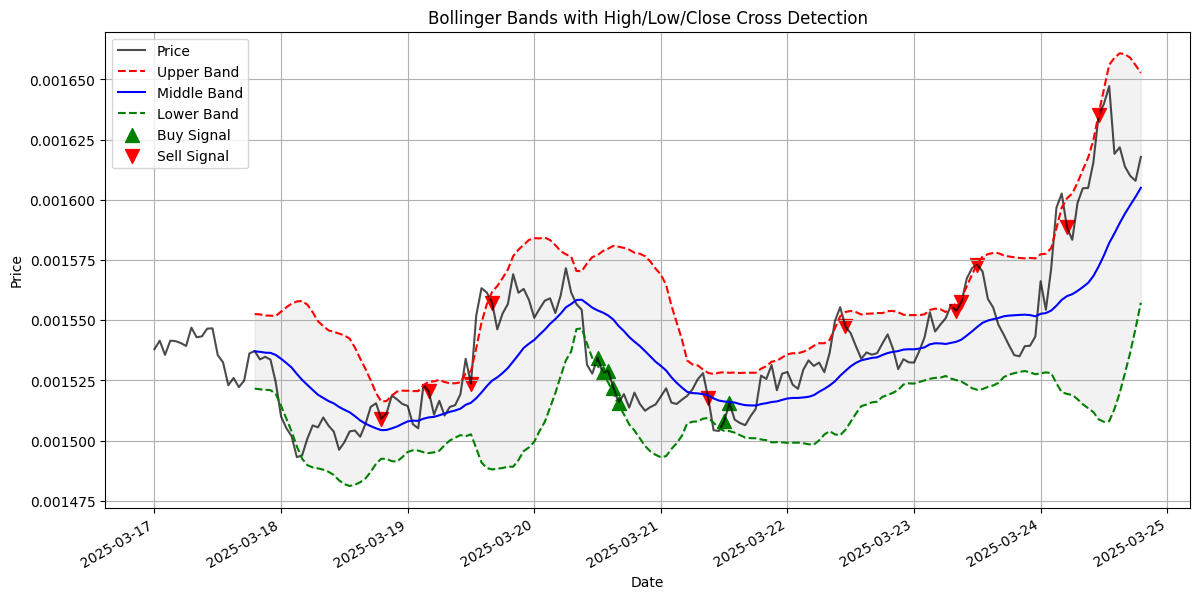

In [10]:
upper, middle, lower = calculate_bollinger_bands(df['close'], window=20, num_std=2)
signals = detect_crosses(df['high'], df['low'], df['close'], upper, lower)
plot_bollinger_bands_with_signals(df, upper, middle, lower, signals)

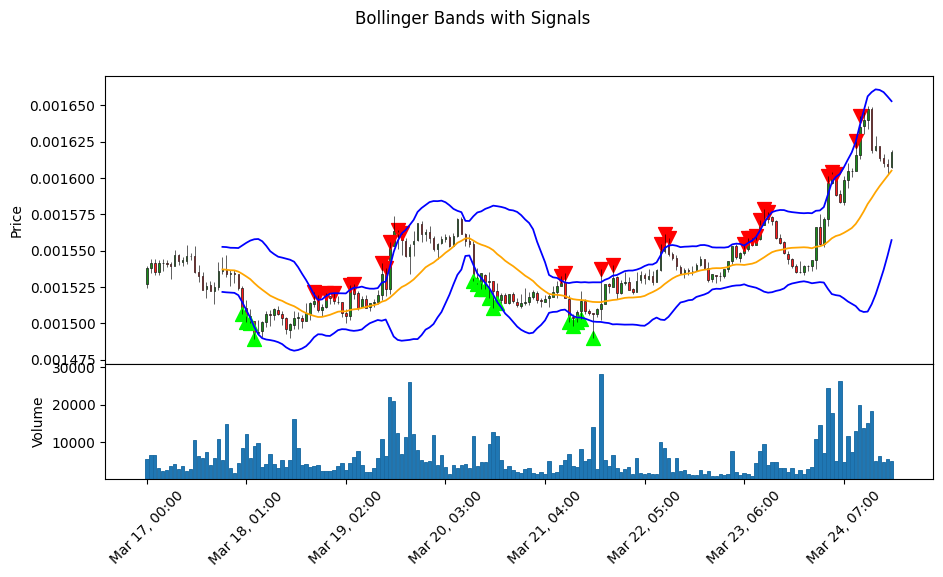

In [13]:
import mplfinance as mpf
import pandas as pd
import numpy as np

# Calculate Bollinger Bands
def calculate_bollinger_bands(close, window=20, num_std=2):
    rolling_mean = close.rolling(window=window).mean()
    rolling_std = close.rolling(window=window).std()
    upper = rolling_mean + (rolling_std * num_std)
    lower = rolling_mean - (rolling_std * num_std)
    return upper, rolling_mean, lower

# Detect signals using high/low/close
def generate_signals(df, upper, lower):
    signals = pd.DataFrame(index=df.index)
    
    # Buy signal: Low was below lower band, then highs back inside
    signals['buy'] = (df['low'] < lower) & (df['high'] >= lower)
    
    # Sell signal: High was above upper band, then lows back inside
    signals['sell'] = (df['high'] > upper) & (df['low'] <= upper)
    
    return signals

# Assuming 'df' has OHLCV data with datetime index
upper, middle, lower = calculate_bollinger_bands(df['close'])
signals = generate_signals(df, upper, lower)

# Create market colors
mc = mpf.make_marketcolors(up='g', down='r')
style = mpf.make_mpf_style(marketcolors=mc)

# Prepare additional plots
apds = [
    mpf.make_addplot(upper, color='blue'),
    mpf.make_addplot(middle, color='orange'),
    mpf.make_addplot(lower, color='blue'),
    mpf.make_addplot(signals['buy'].replace(False, np.nan)*df['low'], 
                    type='scatter', markersize=100, marker='^', color='lime'),
    mpf.make_addplot(signals['sell'].replace(False, np.nan)*df['high'],
                    type='scatter', markersize=100, marker='v', color='red')
]

# Plot everything
mpf.plot(df,
         type='candle',
         style=style,
         addplot=apds,
         volume=True,
         figratio=(16,8),
         title='Bollinger Bands with Signals',
         ylabel='Price',
         ylabel_lower='Volume')